# Neural networks

The most widely used library for neural networks is `torch`. Let's walk through the basics of building a simple fully connected neural network with it.

We will install `torch` without any addons like GPU support (via nvidia's CUDA toolkits) or particular libraries that make certain operations more efficient. Management of data and models across devices is its own subject, so we will only use the CPU-based version of `torch`. For the other versions, check here: https://pytorch.org/get-started/locally/

In [1]:
# install pytorch by running `pip install torch`
import torch

# check that it imports and get the version
print(torch.__version__)

2.1.0


We will grab a dataset we are familiar with from sklearn, and prepare it to be used by our `torch` model.

In [2]:
import sklearn
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

# load our data
dataset = load_diabetes()
x = dataset['data']
y = dataset['target']

# split train and val
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.6)

# split again to get a test set
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, train_size=0.5)

print("x train: ",x_train.shape, "y train:", y_train.shape)
print("x val: ",x_val.shape, "y train:", y_val.shape)
print("x test: ",x_test.shape, "y test:", y_test.shape)

x train:  (265, 10) y train: (265,)
x val:  (88, 10) y train: (88,)
x test:  (89, 10) y test: (89,)


We now need to check to see if our data has any features that are scaled abnormally. Ideally, all our features lie in a -1 to 1 range, where our model will be able to handle it. Features that are too large or small in scale can complicate training a neural network model.

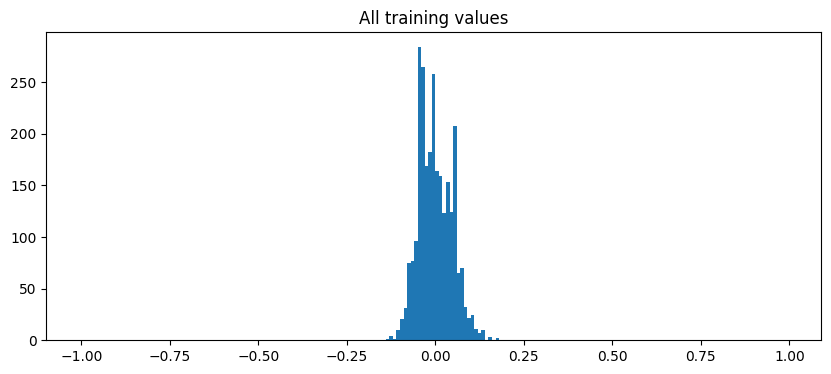

In [3]:
import matplotlib.pyplot as plt

plt.figure(0, figsize=(10,4))
plt.title('All training values')
plt.hist(x_train.flatten(), bins = np.arange(-1,1,0.01));

- Note about test data: We have added a new split to our data, which we can now call our "test" data. When we train a neural network, we usually look at both the training loss and validation loss during training. We would like our validation loss to be close as possible to our training loss, because it indicates our model is not simply "memorizing" the training data. However, we make decisions about our model's hyperparameters (like learning rate, choice of activation functions, width and depth of layers, etc) based on our performance on validation data. This is a kind of overfitting, and so we need a truly unseen dataset to test our model on after training, hence, "test" data.


---------------------


`torch` provides some neat functionality. As input, it wants our data to be of type `torch.Tensor`, and all operations performed on that tensor must also be a `torch` operation. This is because `torch` can do automatic differentiation of almost *any* `torch` operation. Often, simply replacing `numpy` with `torch` is sufficient. So `np.add` could simply be written as `torch.add`.

So, we should transform our data into `torch.Tensors`, which thankfully is very easy to do. The data should stay in this format until it has passed entirely through the model.

In [4]:
print('Type of x_train',type(x_train))
x_train, x_val, x_test = torch.Tensor(x_train), torch.Tensor(x_val), torch.Tensor(x_test)
y_train, y_val, y_test = torch.Tensor(y_train), torch.Tensor(y_val), torch.Tensor(y_test)
print('Type of x_train',type(x_train))

Type of x_train <class 'numpy.ndarray'>
Type of x_train <class 'torch.Tensor'>


### Model definition

We will now construct our model class and call it LearningModel. This will define everything about our model.

In [5]:
import torch.nn as nn

class LearningModel(nn.Module): # this means the class is inheriting all the class attributes of nn.Module
    
    # the __init__ function is called when an instance of the class is created
    def __init__(self):
        super(LearningModel, self).__init__() # lets us call methods from the base class, nn.Module

        # now we can define our layers
        # by prepending self to it, we are storing this as a variable of our class, that can be called elsewhere
        self.linear1 = nn.Linear(in_features = 10, out_features = 64)
        self.linear2 = nn.Linear(in_features = 64, out_features = 32)
        self.linear3 = nn.Linear(in_features = 32, out_features = 1)

        # our activation function
        self.relu = nn.ReLU()

    # the forward function defines how the data flows through each layer of the model, and should return the model's output
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)

        # note that I can do any torch operation I want inside this forward function, and pytorch will automatically calculate
        # my gradient. doesn't just have to be torch.nn layers!
        
        return x

Take a look at the model's parameters

In [6]:
# instantiate our model
model = LearningModel() 

# look at the shape of our model's layers as we defined above
for param in model.parameters():
    print(param.shape)

# look at what these random initialized parameters look like
# we can print out the final parameter from the loop above, which is the bias term of our linear3 layer
print(param)

torch.Size([64, 10])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
Parameter containing:
tensor([-0.0723], requires_grad=True)


Before diving into training, we want to check that our model is compatible with our data. Let's make dummy data and check

In [7]:
model = LearningModel() 

# make a dummy sample the same size of our data
x_dummy = torch.rand(1, 10) 
print(type(x_dummy), x_dummy.shape)

# pass the data through the model. note that model.forward(x_dummy) can also be written as model(x_dummy)
y_dummy = model(x_dummy)
print(type(y_dummy), y_dummy.shape)

<class 'torch.Tensor'> torch.Size([1, 10])
<class 'torch.Tensor'> torch.Size([1, 1])


In [8]:
# see what happens if we pass the wrong size data through. this is an error you will see a lot in model development!
x_dummy = torch.rand(1, 9)
y_dummy = model(x_dummy)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x9 and 10x64)

In [9]:
# see what happens if we pass a numpy array through
x_dummy = np.random.normal(0, 1, (1, 9))
y_dummy = model(x_dummy)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

Put some `print(x.shape)` statements in your forward function and observe how the data changes shape as it passes through the model.

-----------------------

### Model training

In [10]:
import tqdm # handy way to visualize long jobs. pip install tqdm if you don't have this yet

# re-instantiate our model
model = LearningModel()

# define our optimizer. this is what our model will use to update its weights
# we will use the Adam optimizer, which is a well established method https://arxiv.org/pdf/1412.6980.pdf
# we will set the learning rate and pass our model's parameters to the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4) # set learning rate

# set up our training loop. we will do SGD, so one sample at a time
epochs = 200
train_loss = []
val_loss = []

for _ in tqdm.tqdm(range(epochs)):

    # iterate through an entire epoch of training data
    it_loss = []
    model.train() # setting mode of model to train
    for idx in range(len(x_train)):

        # clear out the gradient from prior backward passes
        optimizer.zero_grad()

        # get the model's prediction for that sample
        yhat = model(x_train[idx]) 

        # calculate loss using MAE
        loss = torch.mean(torch.abs(y_train[idx] - yhat))

        # because loss is a tensor that passed through our model, it automatically tracks its history
        # we can calculate the gradient quite simply
        # this computes the gradient of the model parameters that this tensor operated with
        loss.backward() 

        # this updates the model's parameters 
        optimizer.step()

        # log the loss
        # first, "detach" the loss from the computation graph (the thing that tracks the model parameters)
        # second, convert it to a numpy array
        it_loss.append(loss.detach().numpy())
        

    # calculate and append the loss for the entire epoch
    train_loss.append(np.mean(it_loss))

    # pass the validation data through the model, all at once, and calculate its loss (but DONT update weights!)
    model.eval() # setting mode of model to eval
    optimizer.zero_grad()
    yhat = model(x_val)
    loss = torch.mean(torch.abs(y_val - yhat))
    val_loss.append(loss)

100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 16.80it/s]


Visualize training and validation loss throughout training. Because loss alone is difficult to interpret, check to see if the model's predictions are lining up reasonably with the target values.

In [ ]:
import matplotlib.pyplot as plt

print(val_loss[-1], train_loss[-1])

plt.figure(0, figsize = (12,6))
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot([v.detach().numpy() for v in val_loss])
plt.legend(["Training loss","Validation loss"])

fig, axs = plt.subplots(1,2, figsize=(12,6));
axs[0].scatter(model(x_train).detach().numpy(), y_train, color = 'blue')
axs[0].plot([0,300],[0,300], color = 'red', linestyle = '--')
axs[0].set_title('Training Data')
axs[0].set_xlabel('Real')
axs[0].set_ylabel('Predicted')
axs[1].scatter(model(x_val).detach().numpy(), y_val, color = 'orange')
axs[1].plot([0,300],[0,300], color = 'red', linestyle = '--')
axs[1].set_title('Validation Data')
axs[1].set_xlabel('Real')
axs[1].set_ylabel('Predicted')

Congrats! First model trained!

How many times were your model's parameters updated?

- answer: if doing SGD like above, its len(train_data) * num_epochs

How should you interpret the training and validation loss curves above?

- answer: when train_loss < val_loss, the model is overfit to training data. the point at which validation loss is at its minimum is one criteria to choose when to stop your model. this criteria can change depending on what you value about your model.

------------------------------------------

### Model Experimentation

Take some time and experiment with a few things. With each experiment, try running the training loop with the fixed values provided above.

- "Hidden size" of the model, or number of units in each layer (as long as input and output are right sizes, nothing else matters)
- Add or reduce the number of layers in the model.
- Try other activation functions, like `nn.ELU` or `nn.Tanh` or anything from this https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
- Try implementing dropout in the model with `nn.Dropout`. Every forward pass, it chooses a subset of units in the tensor to zero out. This mitigates overfitting by preventing the model from effectively memorizing the data. Note that when it comes time to actually predict your data outside of training, you should call `model.eval()` to turn dropout off. `model.train()` will turn it back on.

### Training Experimentation

You can also experiment with the training routine. Once you have found a model architecture you like, try this out:

- `torch.optim.Adam` is just one optimizer, you can try others found here https://pytorch.org/docs/stable/optim.html.
- Learning rate has a huge impact on training. Try setting it anywhere from 1e-1 to 1e-6 and see how it changes convergence.
- Batch gradient descent changes how quickly the model learns. This dataset should be small enough to fit into memory all at once, so safe to pass the entire train set in at once.
- Try implementing an "early stopping" routine, where training is aborted once some criteria is met.

In [ ]:
# use this space for experimentation



























### Test set

You now have a cool model that you have tinkered on and found a set of hyperparameters that give you good performance on your validation data. Now, we need to see how well the model performs on 100% unseen data, our test data.

Looking at this test data beforehand can bias us dramatically. On a simple dataset like this, hyperparameters may not have a huge impact on the overall model, so the potential negative effect is small. On harder datasets with more complex models, choices of parameters can have a make or break impact on if the model will actually succeed in a real life application.

In [ ]:
# Check to see how our model performs on training data, validation data, and test data
yhat_train = model(x_train).detach().numpy()
yhat_val = model(x_val).detach().numpy()
yhat_test = model(x_test).detach().numpy()

print('Train MAE:', np.mean(np.abs(yhat_train - y_train.numpy())))
print('Val MAE:', np.mean(np.abs(yhat_val - y_val.numpy())))
print('Test MAE:', np.mean(np.abs(yhat_test - y_test.numpy())))

fig, axs = plt.subplots(1,3, figsize=(18,6));

axs[0].scatter(yhat_train, y_train, color = 'blue')
axs[0].plot([0,300],[0,300], color = 'red', linestyle = '--')
axs[0].set_title('Training Data')
axs[0].set_xlabel('Real')
axs[0].set_ylabel('Predicted')

axs[1].scatter(yhat_val, y_val, color = 'orange')
axs[1].plot([0,300],[0,300], color = 'red', linestyle = '--')
axs[1].set_title('Validation Data')
axs[1].set_xlabel('Real')
axs[1].set_ylabel('Predicted')

axs[2].scatter(yhat_test, y_test, color = 'green')
axs[2].plot([0,300],[0,300], color = 'red', linestyle = '--')
axs[2].set_title('Test Data')
axs[2].set_xlabel('Real')
axs[2].set_ylabel('Predicted')